<p><img alt="Colaboratory logo" height="140px" src="https://upload.wikimedia.org/wikipedia/commons/archive/f/fb/20161010213812%21Escudo-UdeA.svg" align="left" hspace="10px" vspace="0px"></p>

# **PROYECTO**

**Reto: Predict CO2 emissions in Rwanda**

**Inteligencia artificial para las ciencias y las ingenierías**

*Facultad de Ingeniería*


**Integrantes:**

* Samuel Gacía Bonilla, CC.1000295970, Ingeniería Eléctrica

* Jhon Fredy Hoyos Cardenas, CC.1045025784 , Ingeniería de Sistemas

* Juan José Bustamante Betancur, CC.1001371385, Ingeniería Eléctrica


**Dataset**

Se hizo una búsqueda de un dataset, en la plataforma Kaggle, que reuniera los requerimientos necesarios para poder llevar a cabo el proyecto ([aquí](https://www.kaggle.com/competitions/playground-series-s3e20/data?select=train.csv) se puede encontrar la página de la competencia).


Para el dataset se seleccionaron aproximadamente 497 ubicaciones únicas de múltiples zonas de Ruanda, con una distribución en torno a tierras de cultivo, ciudades y centrales eléctricas. Los datos para esta competición se dividen por tiempo; los años 2019 - 2021 se incluyen en los datos de entrenamiento (train.csv), y el objetivo es predecir los datos de emisiones de CO2 de 2022 a noviembre.


Se extrajeron siete características principales semanalmente del Sentinel-5P desde enero de 2019 hasta noviembre de 2022. Cada característica (dióxido de azufre, monóxido de carbono, etc.) contiene subcaracterísticas como column_number_density, qué es la densidad de columna vertical a nivel del suelo, calculada mediante la técnica DOAS. Se dan los valores de estas características en el conjunto de pruebas y se busca predecir las emisiones de CO2utilizando información temporal, así como estas características.


* Dióxido de azufre
* Monóxido de carbono
* Dióxido de nitrógeno
* Formaldehído


In [ ]:
# Librerías a usar en todo el proyecto

import pandas as pd

# Librerías para el procesamiento de datos
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta

# Librerías de scikit-learn para Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn import utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,KFold,GroupKFold
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb
import gc
import warnings
warnings.filterwarnings('ignore')

# Lectura del dataset

In [ ]:
# Los datasets se encuentran en un repositorio en Gitlab, se usa wget para descargarlos
!wget -O train.csv https://gitlab.com/fredy.hoyos1/iamireligion/-/raw/a2e8edb223037ba0c74b2aa801e6dce28218f471/train.csv?inline=false
!wget -O test.csv https://gitlab.com/fredy.hoyos1/iamireligion/-/raw/datos/test.csv?inline=false
!wget -O sample_submission.csv https://gitlab.com/fredy.hoyos1/iamireligion/-/raw/datos/sample_submission.csv?inline=false

--2023-11-25 22:03:04--  https://gitlab.com/fredy.hoyos1/iamireligion/-/raw/a2e8edb223037ba0c74b2aa801e6dce28218f471/train.csv?inline=false
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91276119 (87M) [application/octet-stream]
Saving to: ‘train.csv’

train.csv           100%[===================>]  87.05M   113MB/s    in 0.8s    

2023-11-25 22:03:05 (113 MB/s) - ‘train.csv’ saved [91276119/91276119]

--2023-11-25 22:03:05--  https://gitlab.com/fredy.hoyos1/iamireligion/-/raw/datos/test.csv?inline=false
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27625491 (26M) [application/octet-stream]
Saving to: ‘test.csv’

test.csv            100%[===================>]

In [ ]:
# Carga de los archivos CSV
t_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
sample_df = pd.read_csv("sample_submission.csv")

# Mostrar en pantalla las primeras 10 filas del dataset
t_df.head(10)

ID_LAT_LON_YEAR_WEEK  latitude  longitude  year  week_no  \
0  ID_-0.510_29.290_2019_00     -0.51      29.29  2019        0   
1  ID_-0.510_29.290_2019_01     -0.51      29.29  2019        1   
2  ID_-0.510_29.290_2019_02     -0.51      29.29  2019        2   
3  ID_-0.510_29.290_2019_03     -0.51      29.29  2019        3   
4  ID_-0.510_29.290_2019_04     -0.51      29.29  2019        4   
5  ID_-0.510_29.290_2019_05     -0.51      29.29  2019        5   
6  ID_-0.510_29.290_2019_06     -0.51      29.29  2019        6   
7  ID_-0.510_29.290_2019_07     -0.51      29.29  2019        7   
8  ID_-0.510_29.290_2019_08     -0.51      29.29  2019        8   
9  ID_-0.510_29.290_2019_09     -0.51      29.29  2019        9   

   SulphurDioxide_SO2_column_number_density  \
0                                 -0.000108   
1                                  0.000021   
2                                  0.000514   
3                                       NaN   
4                                 -0.000079   
5                                  0.000294   
6                                 -0.000285   
7                                 -0.000016   
8                                 -0.000115   
9                                  0.000056   

   SulphurDioxide_SO2_column_number_density_amf  \
0                                      0.603019   
1                                      0.728214   
2                                      0.748199   
3                                           NaN   
4                                      0.676296   
5                                      0.871713   
6                                      0.791956   
7                                      0.976311   
8                                      0.796941   
9                                      0.998541   

   SulphurDioxide_SO2_slant_column_number_density  \
0                                       -0.000065   
1                                        0.000014   
2                                        0.000385   
3                                             NaN   
4                                       -0.000048   
5                                        0.000242   
6                                       -0.000226   
7                                       -0.000016   
8                                       -0.000101   
9                                        0.000014   

   SulphurDioxide_cloud_fraction  SulphurDioxide_sensor_azimuth_angle  ...  \
0                       0.255668                           -98.593887  ...   
1                       0.130988                            16.592861  ...   
2                       0.110018                            72.795837  ...   
3                            NaN                                  NaN  ...   
4                       0.121164                             4.121269  ...   
5                       0.227656                           -13.453690  ...   
6                       0.119397                            72.198647  ...   
7                       0.106799                          -100.956055  ...   
8                       0.164971                           -40.179074  ...   
9                       0.157726                          -100.108744  ...   

   Cloud_cloud_top_height  Cloud_cloud_base_pressure  Cloud_cloud_base_height  \
0             3664.436218               61085.809570              2615.120483   
1             3651.190311               66969.478735              3174.572424   
2             4216.986492               60068.894448              3516.282669   
3             5228.507736               51064.547339              4180.973322   
4             3980.598120               63751.125781              3355.710107   
5             5530.354546               49846.001010              4495.301362   
6             4378.614648               58804.276563              3537.050659   
7             3468.924146               63697.007267              2597.071563   
8             316

# Procesamiento inicial de los datos

In [ ]:
# Tamaño del dataset orginial

t_df.shape

(79023, 76)

In [ ]:
# Modificación del dataset original
# Se remueven columnas que no son necesarias para el análisis

remove = [col for col in t_df.columns if 'UvAerosolLayer' in col]
train_df = t_df.drop(columns= remove) # Nueva variable para el dataset
train_df.shape

(79023, 69)

Se agregan las columnas categóricas faltantes que corresponden a la columna cuartil y a la columna mes

* **Quartile**


In [ ]:
# Crear columna Quartile

# Crear un DataFrame con una columna que siga el patrón 1, 2, 3, 4 repetido hasta 79023

patron = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
          2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4,
          4, 4, 4, 4, 4, 4]
repeticiones = 79023 // len(patron)  # Calcula cuántas veces se debe repetir el patrón
columna = patron * repeticiones  # Crea la columna con el patrón repetido

# Completa la columna con los valores restantes si es necesario
faltantes = 79023 - len(columna)
columna += patron[:faltantes]

train_df['Quartile'] = columna

* **month**

In [ ]:
# Crear columna month_no

# Se crea una función para obtener el número de mes a partir del número de semana y año

def mes(row):
    """
    Función que permite sacar el mes a partir del número de la semana.
    """
    año_base = row['year']
    semana = row['week_no']

    # Calculamos la fecha del primer día del año
    primer_dia_del_año = datetime(año_base, 1, 1)
    # Calculamos la fecha correspondiente al inicio de la semana dada
    fecha_inicio_semana = primer_dia_del_año + timedelta(weeks=semana)
    # Obtenemos el número de mes
    numero_mes = fecha_inicio_semana.month

    return numero_mes

# Se aplica la función a las filas del DataFrame y creamos una nueva columna 'mes'
train_df['month_no'] = train_df.apply(mes, axis=1)

In [ ]:
# Desplazamiento de las columnas

# Especifica el nombre de la columna que deseas mover
columna_a_mover = 'month_no'
columna_a_mover1 = 'Quartile'

# Elimina la columna de su posición actual y guárdala en una variable temporal
columna_temporal = train_df.pop(columna_a_mover)
columna_temporal1 = train_df.pop(columna_a_mover1)

# Inserta la columna en la nueva posición
nueva_posicion = 5  # Puedes ajustar esta posición según tus necesidades
nueva_posicion1 = 6

train_df.insert(nueva_posicion, columna_a_mover, columna_temporal)
train_df.insert(nueva_posicion1, columna_a_mover1, columna_temporal1)

# Muestra el DataFrame resultante
train_df.head(10)

ID_LAT_LON_YEAR_WEEK  latitude  longitude  year  week_no  month_no  \
0  ID_-0.510_29.290_2019_00     -0.51      29.29  2019        0         1   
1  ID_-0.510_29.290_2019_01     -0.51      29.29  2019        1         1   
2  ID_-0.510_29.290_2019_02     -0.51      29.29  2019        2         1   
3  ID_-0.510_29.290_2019_03     -0.51      29.29  2019        3         1   
4  ID_-0.510_29.290_2019_04     -0.51      29.29  2019        4         1   
5  ID_-0.510_29.290_2019_05     -0.51      29.29  2019        5         2   
6  ID_-0.510_29.290_2019_06     -0.51      29.29  2019        6         2   
7  ID_-0.510_29.290_2019_07     -0.51      29.29  2019        7         2   
8  ID_-0.510_29.290_2019_08     -0.51      29.29  2019        8         2   
9  ID_-0.510_29.290_2019_09     -0.51      29.29  2019        9         3   

   Quartile  SulphurDioxide_SO2_column_number_density  \
0         1                                 -0.000108   
1         1                                  0.000021   
2         1                                  0.000514   
3         1                                       NaN   
4         1                                 -0.000079   
5         1                                  0.000294   
6         1                                 -0.000285   
7         1                                 -0.000016   
8         1                                 -0.000115   
9         1                                  0.000056   

   SulphurDioxide_SO2_column_number_density_amf  \
0                                      0.603019   
1                                      0.728214   
2                                      0.748199   
3                                           NaN   
4                                      0.676296   
5                                      0.871713   
6                                      0.791956   
7                                      0.976311   
8                                      0.796941   
9                                      0.998541   

   SulphurDioxide_SO2_slant_column_number_density  ...  \
0                                       -0.000065  ...   
1                                        0.000014  ...   
2                                        0.000385  ...   
3                                             NaN  ...   
4                                       -0.000048  ...   
5                                        0.000242  ...   
6                                       -0.000226  ...   
7                                       -0.000016  ...   
8                                       -0.000101  ...   
9                                        0.000014  ...   

   Cloud_cloud_top_height  Cloud_cloud_base_pressure  Cloud_cloud_base_height  \
0             3664.436218               61085.809570              2615.120483   
1             3651.190311               66969.478735              3174.572424   
2             4216.986492               60068.894448              3516.282669   
3             5228.507736               51064.547339              4180.973322   
4             3980.598120               63751.125781              3355.710107   
5             5530.354546               49846.001010              4495.301362   
6             4378.614648               58804.276563              3537.050659   
7             3468.924146               63697.007267              2597.071563   
8             3160.264670               67222.556159              2530.851476   
9             4141.073340               60298.717969              3510.293652   

   Cloud_cloud_optical_depth  Cloud_surface_albedo  \
0                  15.568533              0.272292   
1                   8.690601              0.256830   
2                  21.103410              0.251101   
3                  15.386899              0.262043   
4                   8.114694              0.235847   
5                   7.556143              0.250228   
6                  10.493107              0.240828   
7     

In [ ]:
# Se definen las variables categóricas
train_df['ID_LAT_LON_YEAR_WEEK'] = train_df['ID_LAT_LON_YEAR_WEEK'].astype('category')
train_df['latitude'] = train_df['latitude'].astype('category')
train_df['longitude'] = train_df['longitude'].astype('category')
train_df['year'] = train_df['year'].astype('category')
train_df['week_no'] = train_df['week_no'].astype('category')
train_df['month_no'] = train_df['month_no'].astype('category')
train_df['Quartile'] = train_df['Quartile'].astype('category')

In [ ]:
# Se muestran el tipo de cada una de las columnas
for c in train_df.columns:
    print ("%20s"%c, train_df[c].dtype)

ID_LAT_LON_YEAR_WEEK category
            latitude category
           longitude category
                year category
             week_no category
            month_no category
            Quartile category
SulphurDioxide_SO2_column_number_density float64
SulphurDioxide_SO2_column_number_density_amf float64
SulphurDioxide_SO2_slant_column_number_density float64
SulphurDioxide_cloud_fraction float64
SulphurDioxide_sensor_azimuth_angle float64
SulphurDioxide_sensor_zenith_angle float64
SulphurDioxide_solar_azimuth_angle float64
SulphurDioxide_solar_zenith_angle float64
SulphurDioxide_SO2_column_number_density_15km float64
CarbonMonoxide_CO_column_number_density float64
CarbonMonoxide_H2O_column_number_density float64
CarbonMonoxide_cloud_height float64
CarbonMonoxide_sensor_altitude float64
CarbonMonoxide_sensor_azimuth_angle float64
CarbonMonoxide_sensor_zenith_angle float64
CarbonMonoxide_solar_azimuth_angle float64
CarbonMonoxide_solar_zenith_angle float64
NitrogenDioxide_NO2_colum

#Procesamiento adicional de los datos

In [ ]:
# Se unifican tanto la longitud como la latitud
train_df['location'] = [str(x) + '_' + str(y) for x, y in zip(train_df.latitude, train_df.longitude)]

## Reemplazo de datos faltantes

Revisión del porcentaje de datos faltantes

In [ ]:
#Porcentaje de datos faltantes para cada variable del dataset
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()*100).sort_values(ascending=False)
missing_train = pd.concat([total,percent],axis=1,keys=["Total","Percent"])
missing_train

In [ ]:
# Seleccionar solo las columnas numéricas
columnas_numericas = train_df.select_dtypes(include=['number'])

# Reemplazar los valores nulos en las columnas numéricas
columnas_numericas_filled = columnas_numericas.fillna((columnas_numericas.ffill() + columnas_numericas.bfill()) / 2)

# Mantener las columnas categóricas sin cambios
train_df = pd.concat([columnas_numericas_filled, train_df.select_dtypes(exclude=['number'])], axis=1)

# Se muestra el DataFrame resultante
train_df.head(10)

SulphurDioxide_SO2_column_number_density  \
0                                 -0.000108   
1                                  0.000021   
2                                  0.000514   
3                                  0.000218   
4                                 -0.000079   
5                                  0.000294   
6                                 -0.000285   
7                                 -0.000016   
8                                 -0.000115   
9                                  0.000056   

   SulphurDioxide_SO2_column_number_density_amf  \
0                                      0.603019   
1                                      0.728214   
2                                      0.748199   
3                                      0.712247   
4                                      0.676296   
5                                      0.871713   
6                                      0.791956   
7                                      0.976311   
8                                      0.796941   
9                                      0.998541   

   SulphurDioxide_SO2_slant_column_number_density  \
0                                       -0.000065   
1                                        0.000014   
2                                        0.000385   
3                                        0.000169   
4                                       -0.000048   
5                                        0.000242   
6                                       -0.000226   
7                                       -0.000016   
8                                       -0.000101   
9                                        0.000014   

   SulphurDioxide_cloud_fraction  SulphurDioxide_sensor_azimuth_angle  \
0                       0.255668                           -98.593887   
1                       0.130988                            16.592861   
2                       0.110018                            72.795837   
3                       0.115591                            38.458553   
4                       0.121164                             4.121269   
5                       0.227656                           -13.453690   
6                       0.119397                            72.198647   
7                       0.106799                          -100.956055   
8                       0.164971                           -40.179074   
9                       0.157726                          -100.108744   

   SulphurDioxide_sensor_zenith_angle  SulphurDioxide_solar_azimuth_angle  \
0                           50.843559                         -130.050797   
1                           39.137194                         -140.874435   
2                           52.868816                         -150.191757   
3                           44.192202                         -143.800458   
4                           35.515587                         -137.409159   
5                           57.097124                         -136.616859   
6                           58.496368                         -143.726913   
7                           23.739841                         -114.887650   
8                           31.161560                         -109.595605   
9                           33.592015                         -101.944155   

   SulphurDioxide_solar_zenith_angle  \
0                          35.874496   
1                          28.965133   
2                          23.206415   
3                          23.769194   
4                          24.331972   
5                          23.408866   
6                          15.767768   
7                          24.024235   
8                          25.046363   
9                          24.675413   

   SulphurDioxide_SO2_column_number_density_15km  \
0                                      -0.000027   
1                                       0.000012   
2                                       0.000154   
3                                     

In [ ]:
# Se realiza una copia del dataset para los modelos posteriores
train_ndf = train_df.copy()
train_ndf.head()

SulphurDioxide_SO2_column_number_density  \
0                                 -0.000108   
1                                  0.000021   
2                                  0.000514   
3                                  0.000218   
4                                 -0.000079   

   SulphurDioxide_SO2_column_number_density_amf  \
0                                      0.603019   
1                                      0.728214   
2                                      0.748199   
3                                      0.712247   
4                                      0.676296   

   SulphurDioxide_SO2_slant_column_number_density  \
0                                       -0.000065   
1                                        0.000014   
2                                        0.000385   
3                                        0.000169   
4                                       -0.000048   

   SulphurDioxide_cloud_fraction  SulphurDioxide_sensor_azimuth_angle  \
0                       0.255668                           -98.593887   
1                       0.130988                            16.592861   
2                       0.110018                            72.795837   
3                       0.115591                            38.458553   
4                       0.121164                             4.121269   

   SulphurDioxide_sensor_zenith_angle  SulphurDioxide_solar_azimuth_angle  \
0                           50.843559                         -130.050797   
1                           39.137194                         -140.874435   
2                           52.868816                         -150.191757   
3                           44.192202                         -143.800458   
4                           35.515587                         -137.409159   

   SulphurDioxide_solar_zenith_angle  \
0                          35.874496   
1                          28.965133   
2                          23.206415   
3                          23.769194   
4                          24.331972   

   SulphurDioxide_SO2_column_number_density_15km  \
0                                      -0.000027   
1                                       0.000012   
2                                       0.000154   
3                                       0.000063   
4                                      -0.000028   

   CarbonMonoxide_CO_column_number_density  ...  Cloud_solar_zenith_angle  \
0                                 0.035370  ...                 30.752140   
1                                 0.036526  ...                 27.251779   
2                                 0.035338  ...                 26.193296   
3                                 0.036790  ...                 28.829155   
4                                 0.034675  ...                 22.204612   

   emission      ID_LAT_LON_YEAR_WEEK  latitude  longitude  year  week_no  \
0  3.750994  ID_-0.510_29.290_2019_00     -0.51      29.29  2019        0   
1  4.025176  ID_-0.510_29.290_2019_01     -0.51      29.29  2019        1   
2  4.231381  ID_-0.510_29.290_2019_02     -0.51      29.29  2019        2   
3  4.305286  ID_-0.510_29.290_2019_03     -0.51      29.29  2019        3   
4  4.347317  ID_-0.510_29.290_2019_04     -0.51      29.29  2019        4   

   month_no  Quartile     location  
0         1         1  -0.51_29.29  
1         1         1  -0.51_29.29  
2         1         1  -0.51_29.29  
3         1         1  -0.51_29.29  
4         1         1  -0.51_29.29  

[5 rows x 72 columns]

In [ ]:
# Se convierten las variables categóricas a numéricas para analizar posteriormente
var_categoricas = ['ID_LAT_LON_YEAR_WEEK','latitude', 'longitude', 'year', 'week_no', 'month_no', 'Quartile', 'location']
encoder = preprocessing.LabelEncoder()

for i in var_categoricas:

    train_ndf[i] = encoder.fit_transform(train_df[i])

print (train_ndf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79023 entries, 0 to 79022
Data columns (total 72 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   SulphurDioxide_SO2_column_number_density                  79023 non-null  float64
 1   SulphurDioxide_SO2_column_number_density_amf              79023 non-null  float64
 2   SulphurDioxide_SO2_slant_column_number_density            79023 non-null  float64
 3   SulphurDioxide_cloud_fraction                             79023 non-null  float64
 4   SulphurDioxide_sensor_azimuth_angle                       79023 non-null  float64
 5   SulphurDioxide_sensor_zenith_angle                        79023 non-null  float64
 6   SulphurDioxide_solar_azimuth_angle                        79023 non-null  float64
 7   SulphurDioxide_solar_zenith_angle                         79023 non-null  float64
 8   SulphurDioxide_S

In [ ]:
# Resumen estadístico de los datos

train_df._get_numeric_data().describe().T

count       mean  \
SulphurDioxide_SO2_column_number_density        79023.0   0.000050   
SulphurDioxide_SO2_column_number_density_amf    79023.0   0.840022   
SulphurDioxide_SO2_slant_column_number_density  79023.0   0.000037   
SulphurDioxide_cloud_fraction                   79023.0   0.160464   
SulphurDioxide_sensor_azimuth_angle             79023.0  -7.270983   
...                                                 ...        ...   
Cloud_sensor_azimuth_angle                      79023.0 -10.824450   
Cloud_sensor_zenith_angle                       79023.0  40.426150   
Cloud_solar_azimuth_angle                       79023.0 -87.106908   
Cloud_solar_zenith_angle                        79023.0  27.947463   
emission                                        79023.0  81.940552   

                                                       std         min  \
SulphurDioxide_SO2_column_number_density          0.000266   -0.000996   
SulphurDioxide_SO2_column_number_density_amf      0.179652    0.241822   
SulphurDioxide_SO2_slant_column_number_density    0.000203   -0.000887   
SulphurDioxide_cloud_fraction                     0.068871    0.000000   
SulphurDioxide_sensor_azimuth_angle              62.230517 -179.537059   
...                                                    ...         ...   
Cloud_sensor_azimuth_angle                       30.290652 -102.739731   
Cloud_sensor_zenith_angle                         6.410963    2.998873   
Cloud_solar_azimuth_angle                        37.923922 -153.464211   
Cloud_solar_zenith_angle                          4.399026   10.818288   
emission                                        144.299648    0.000000   

                                                       25%        50%  \
SulphurDioxide_SO2_column_number_density         -0.000091   0.000025   
SulphurDioxide_SO2_column_number_density_amf      0.715423   0.818968   
SulphurDioxide_SO2_slant_column_number_density   -0.000075   0.000020   
SulphurDioxide_cloud_fraction                     0.114917   0.164180   
SulphurDioxide_sensor_azimuth_angle             -55.817874 -12.343056   
...                                                    ...        ...   
Cloud_sensor_azimuth_angle                      -30.277034 -12.666715   
Cloud_sensor_zenith_angle                        35.850407  41.074076   
Cloud_solar_azimuth_angle                      -126.480135 -85.395413   
Cloud_solar_zenith_angle                         24.713837  28.375570   
emission                                          9.797995  45.593445   

                                                       75%          max  
SulphurDioxide_SO2_column_number_density          0.000150     0.004191  
SulphurDioxide_SO2_column_number_density_amf      0.945408     1.885239  
SulphurDioxide_SO2_slant_column_number_density    0.000120     0.004236  
SulphurDioxide_cloud_fraction                     0.211129     0.299998  
SulphurDioxide_sensor_azimuth_angle              60.904192   122.095200  
...                                                    ...          ...  
Cloud_sensor_azimuth_angle                        9.250658    78.223037  
Cloud_sensor_zenith_angle                        44.424141    65.951248  
Cloud_solar_azimuth_angle                       -48.283747   -22.653170  
Cloud_solar_zenith_angle                         31.505145    42.060436  
emission                                        109.549595  3167.768000  

[64 rows x 8 columns]

In [ ]:
# Resumen estadístico de los datos

train_ndf._get_numeric_data().describe().T

count        mean  \
SulphurDioxide_SO2_column_number_density        79023.0    0.000050   
SulphurDioxide_SO2_column_number_density_amf    79023.0    0.840022   
SulphurDioxide_SO2_slant_column_number_density  79023.0    0.000037   
SulphurDioxide_cloud_fraction                   79023.0    0.160464   
SulphurDioxide_sensor_azimuth_angle             79023.0   -7.270983   
...                                                 ...         ...   
year                                            79023.0    1.000000   
week_no                                         79023.0   26.000000   
month_no                                        79023.0    5.522013   
Quartile                                        79023.0    1.499728   
location                                        79023.0  248.000000   

                                                       std         min  \
SulphurDioxide_SO2_column_number_density          0.000266   -0.000996   
SulphurDioxide_SO2_column_number_density_amf      0.179652    0.241822   
SulphurDioxide_SO2_slant_column_number_density    0.000203   -0.000887   
SulphurDioxide_cloud_fraction                     0.068871    0.000000   
SulphurDioxide_sensor_azimuth_angle              62.230517 -179.537059   
...                                                    ...         ...   
year                                              0.816502    0.000000   
week_no                                          15.297155    0.000000   
month_no                                          3.499953    0.000000   
Quartile                                          1.117990    0.000000   
location                                        143.472159    0.000000   

                                                       25%         50%  \
SulphurDioxide_SO2_column_number_density         -0.000091    0.000025   
SulphurDioxide_SO2_column_number_density_amf      0.715423    0.818968   
SulphurDioxide_SO2_slant_column_number_density   -0.000075    0.000020   
SulphurDioxide_cloud_fraction                     0.114917    0.164180   
SulphurDioxide_sensor_azimuth_angle             -55.817874  -12.343056   
...                                                    ...         ...   
year                                              0.000000    1.000000   
week_no                                          13.000000   26.000000   
month_no                                          3.000000    6.000000   
Quartile                                          0.000000    1.000000   
location                                        124.000000  248.000000   

                                                       75%         max  
SulphurDioxide_SO2_column_number_density          0.000150    0.004191  
SulphurDioxide_SO2_column_number_density_amf      0.945408    1.885239  
SulphurDioxide_SO2_slant_column_number_density    0.000120    0.004236  
SulphurDioxide_cloud_fraction                     0.211129    0.299998  
SulphurDioxide_sensor_azimuth_angle              60.904192  122.095200  
...                                                    ...         ...  
year                                              2.000000    2.000000  
week_no                                          39.000000   52.000000  
month_no                                          9.000000   11.000000  
Quartile                                          2.000000    3.000000  
location                                        372.000000  496.000000  

[72 rows x 8 columns]

In [ ]:
# Cantidad de valores nulos resultantes

k = train_df.isna().sum()
k[k!=0]

NitrogenDioxide_NO2_column_number_density                  1
NitrogenDioxide_tropospheric_NO2_column_number_density     1
NitrogenDioxide_stratospheric_NO2_column_number_density    1
NitrogenDioxide_NO2_slant_column_number_density            1
NitrogenDioxide_tropopause_pressure                        1
NitrogenDioxide_absorbing_aerosol_index                    1
NitrogenDioxide_cloud_fraction                             1
NitrogenDioxide_sensor_altitude                            1
NitrogenDioxide_sensor_azimuth_angle                       1
NitrogenDioxide_sensor_zenith_angle                        1
NitrogenDioxide_solar_azimuth_angle                        1
NitrogenDioxide_solar_zenith_angle                         1
dtype: int64

In [ ]:
# Cantidad de valores nulos resultantes

k = train_ndf.isna().sum()
k[k!=0]

NitrogenDioxide_NO2_column_number_density                  1
NitrogenDioxide_tropospheric_NO2_column_number_density     1
NitrogenDioxide_stratospheric_NO2_column_number_density    1
NitrogenDioxide_NO2_slant_column_number_density            1
NitrogenDioxide_tropopause_pressure                        1
NitrogenDioxide_absorbing_aerosol_index                    1
NitrogenDioxide_cloud_fraction                             1
NitrogenDioxide_sensor_altitude                            1
NitrogenDioxide_sensor_azimuth_angle                       1
NitrogenDioxide_sensor_zenith_angle                        1
NitrogenDioxide_solar_azimuth_angle                        1
NitrogenDioxide_solar_zenith_angle                         1
dtype: int64

## Correlación de variables

In [ ]:
# Se define la matriz de correlaciones
corr_matrix = train_ndf.corr()

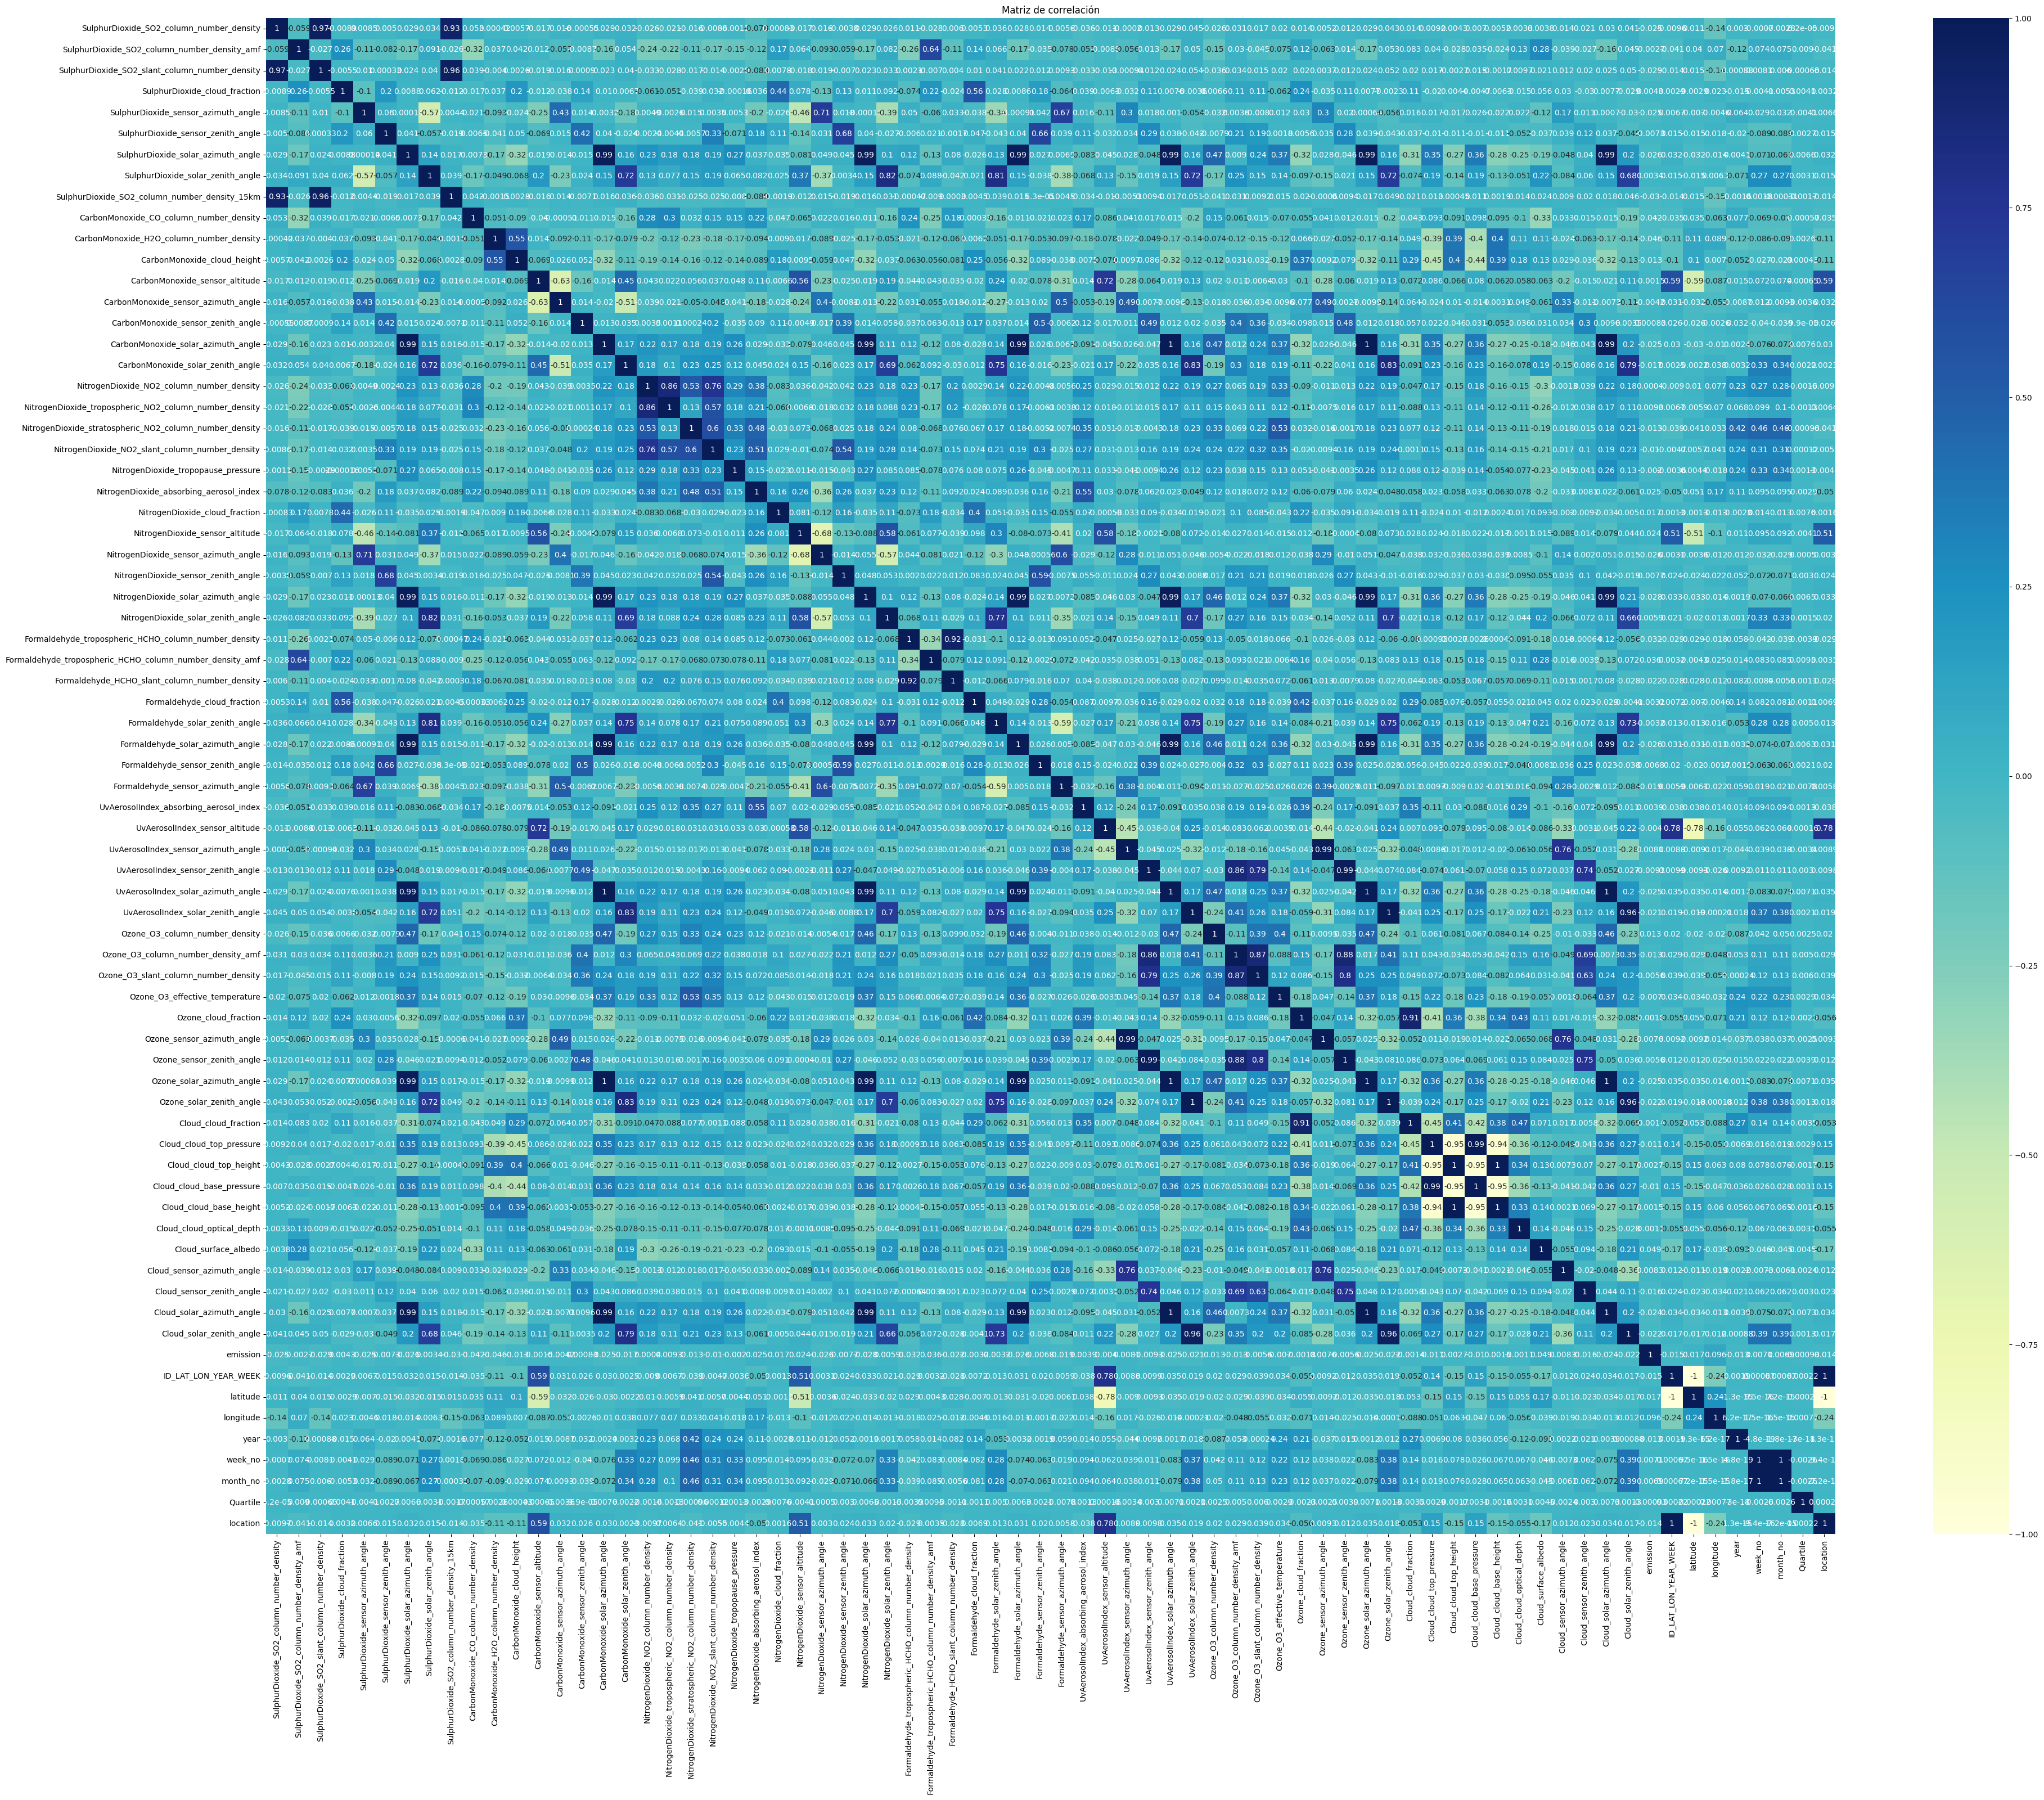

In [ ]:
# Se realiza el gráfico de la matriz de correlaciones
plt.figure(figsize=(45,35))
sns.heatmap(corr_matrix, annot = True, vmin = -1, vmax = 1, cmap = "YlGnBu").set_title('Matriz de correlación')
plt.show()

In [ ]:
# Se observan las correlaciones de las variables con la variable objetivo
target_corr_ndf = pd.DataFrame(corr_matrix["emission"].sort_values(ascending=False))
target_corr_ndf

emission
emission                                            1.000000
longitude                                           0.095721
Cloud_surface_albedo                                0.048503
Formaldehyde_tropospheric_HCHO_column_number_de...  0.036187
NitrogenDioxide_absorbing_aerosol_index             0.024680
...                                                      ...
SulphurDioxide_SO2_slant_column_number_density     -0.028685
SulphurDioxide_SO2_column_number_density_15km      -0.029705
Formaldehyde_tropospheric_HCHO_column_number_de... -0.032184
CarbonMonoxide_CO_column_number_density            -0.042090
CarbonMonoxide_H2O_column_number_density           -0.046091

[72 rows x 1 columns]

##Distribución de todas las variables númericas

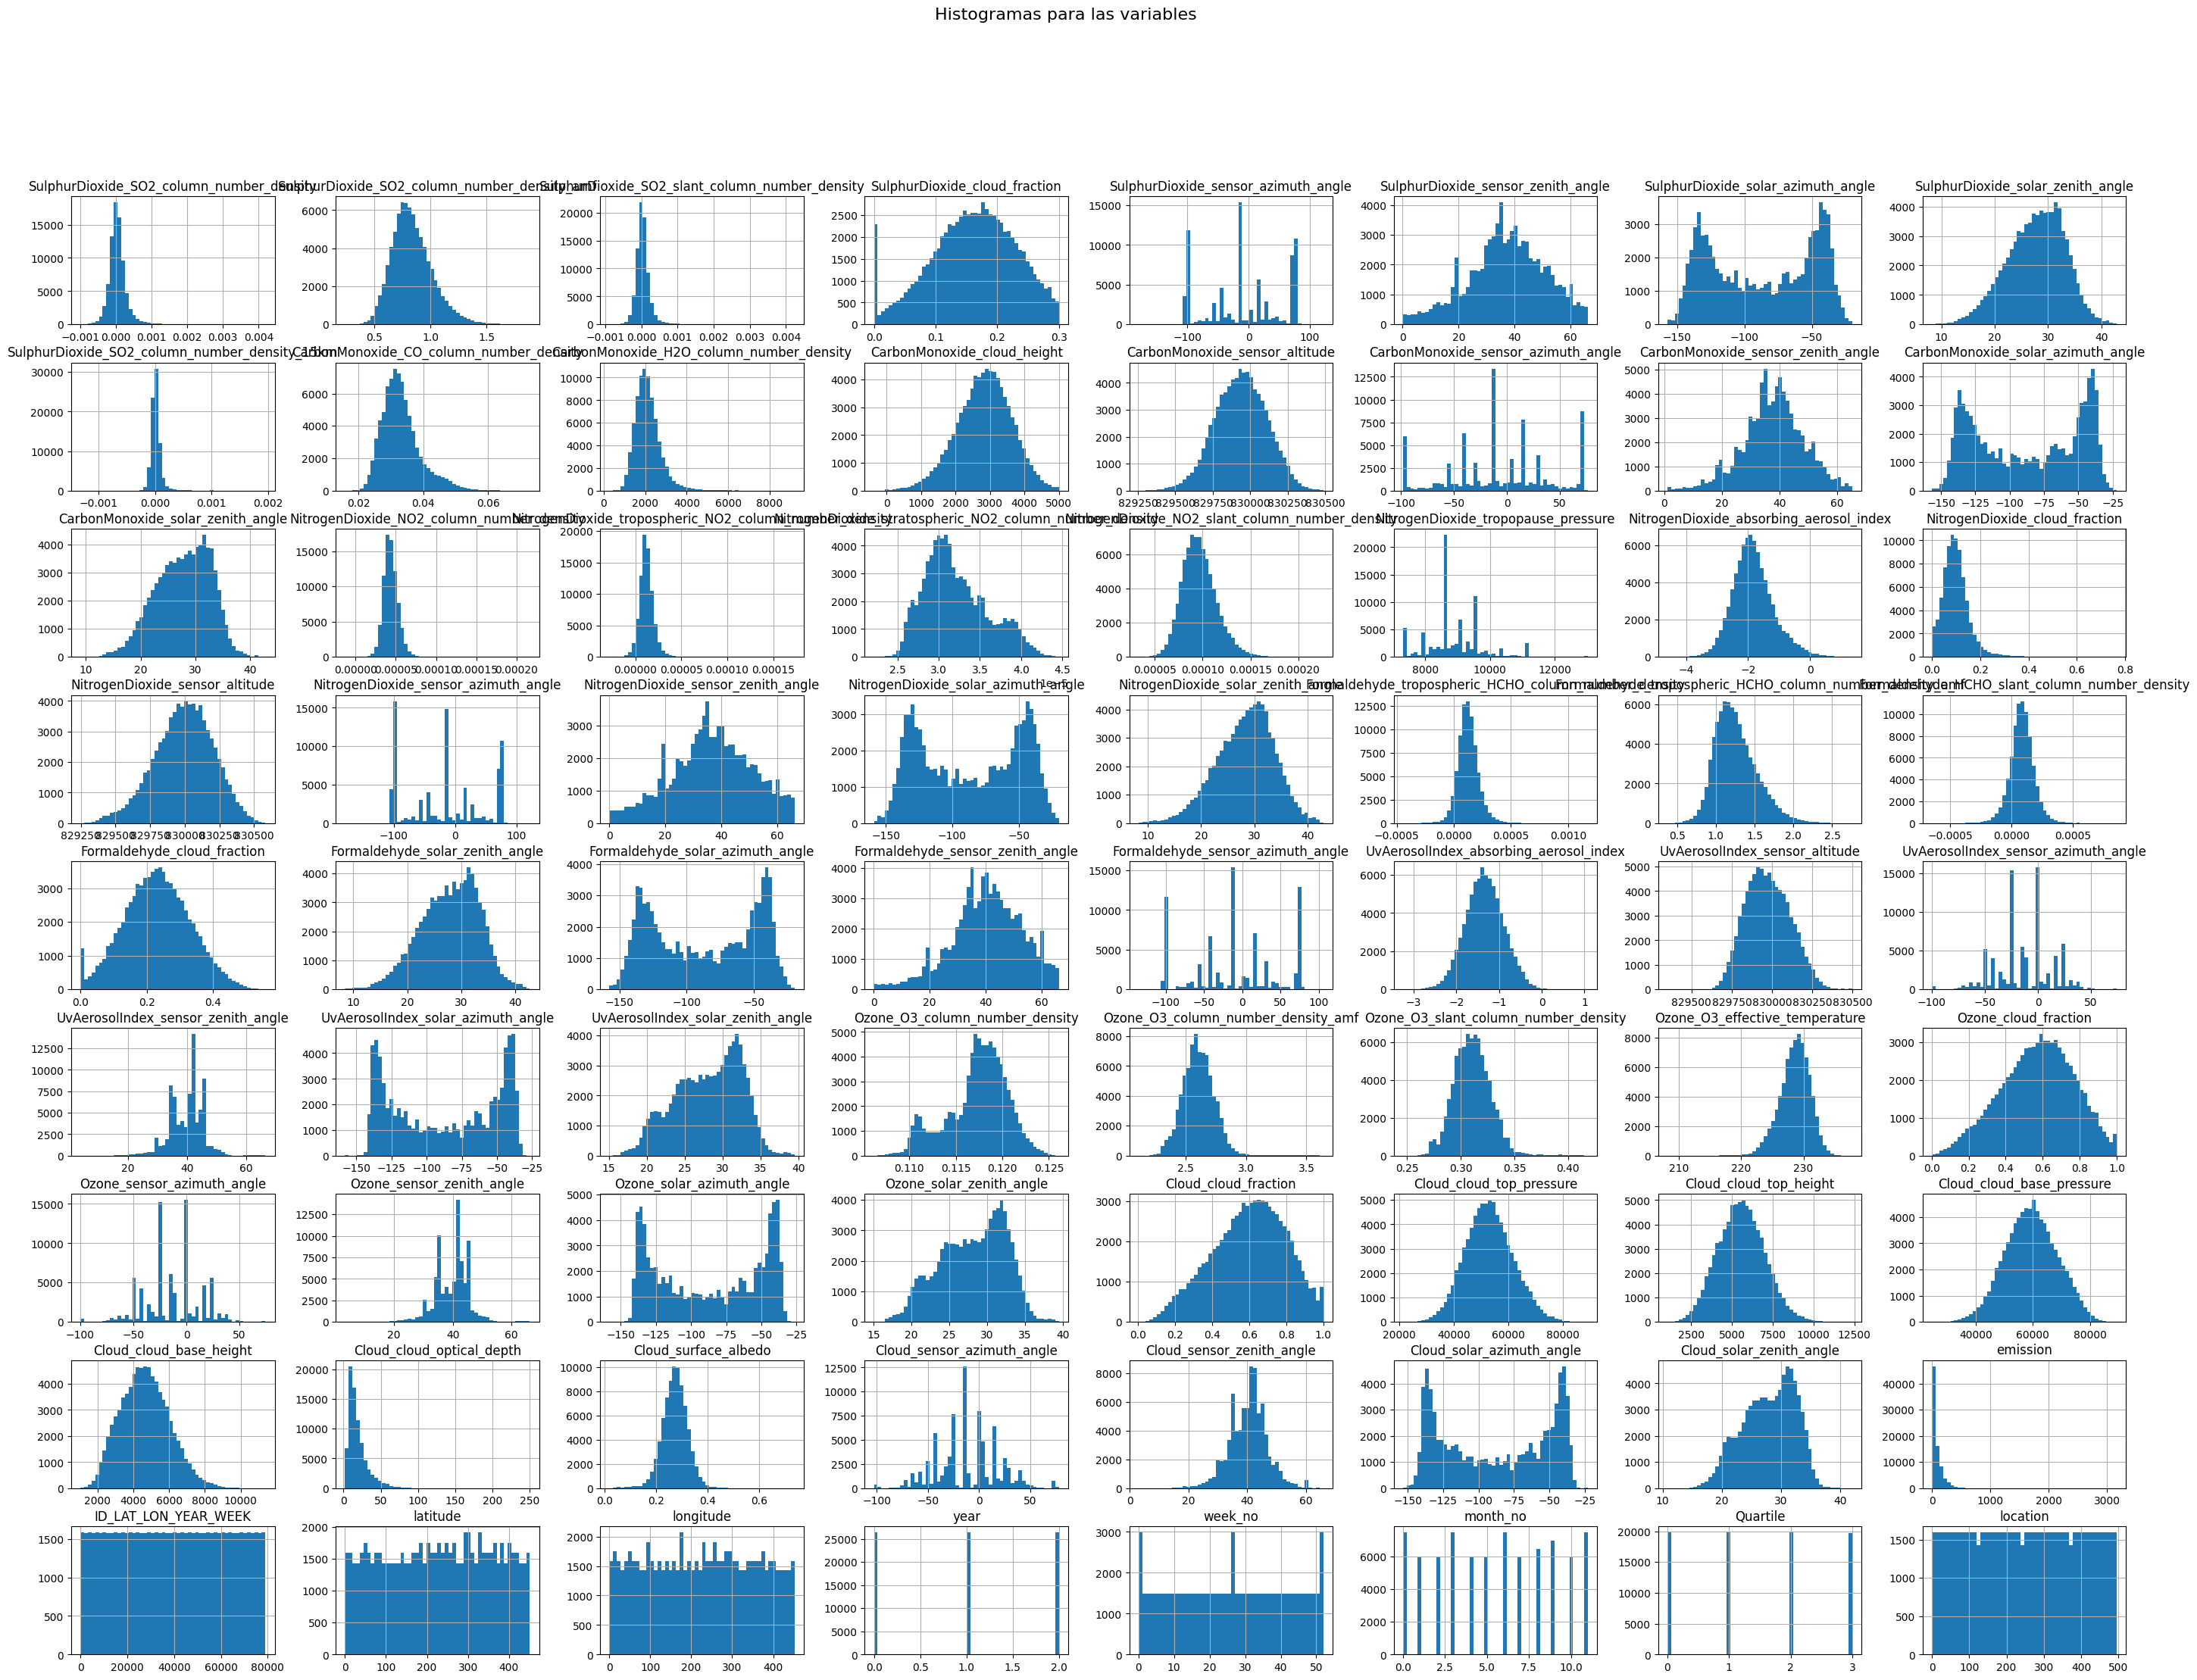

In [ ]:
# Gráficos de los histogramas de las distribuciones de las variables
train_ndf.hist(bins=50, figsize=(35,25))
plt.suptitle('Histogramas para las variables', fontsize=16)
plt.show()

## Variable objetivo: "emission"

<Axes: xlabel='emission', ylabel='Density'>

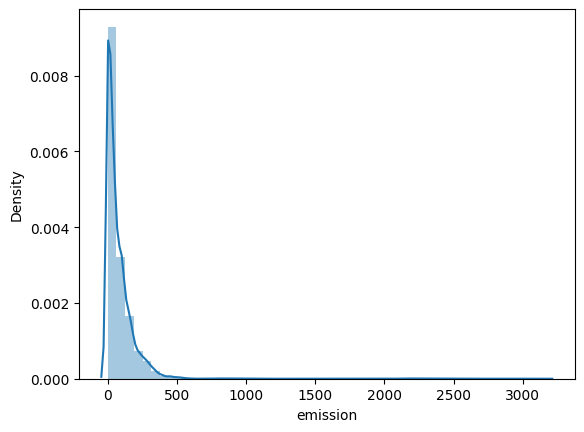

In [ ]:
# Distribución de la variable objetivo
sns.distplot(train_ndf['emission'])

Para la segunda iteración se hace una transformación logarítimica debido a la distribución sesgada a la derecha.

In [ ]:
print('Asimetría de la variable objetivo', train_ndf['emission'].skew())

Asimetría de la variable objetivo 10.173825825101622


In [ ]:
# Transformación logaritmica de la variable objetivo
train_ndf['emission']=np.log1p(train_ndf['emission'])

<Axes: xlabel='emission', ylabel='Density'>

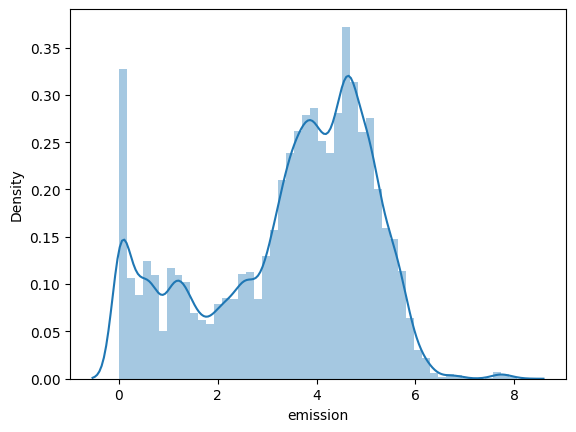

In [ ]:
sns.distplot(train_ndf['emission'])

In [ ]:
print('Nuevo coeficiente de asimetría de la variable transformada', train_ndf['emission'].skew())

Nuevo coeficiente de asimetría de la variable transformada -0.6091471436943189


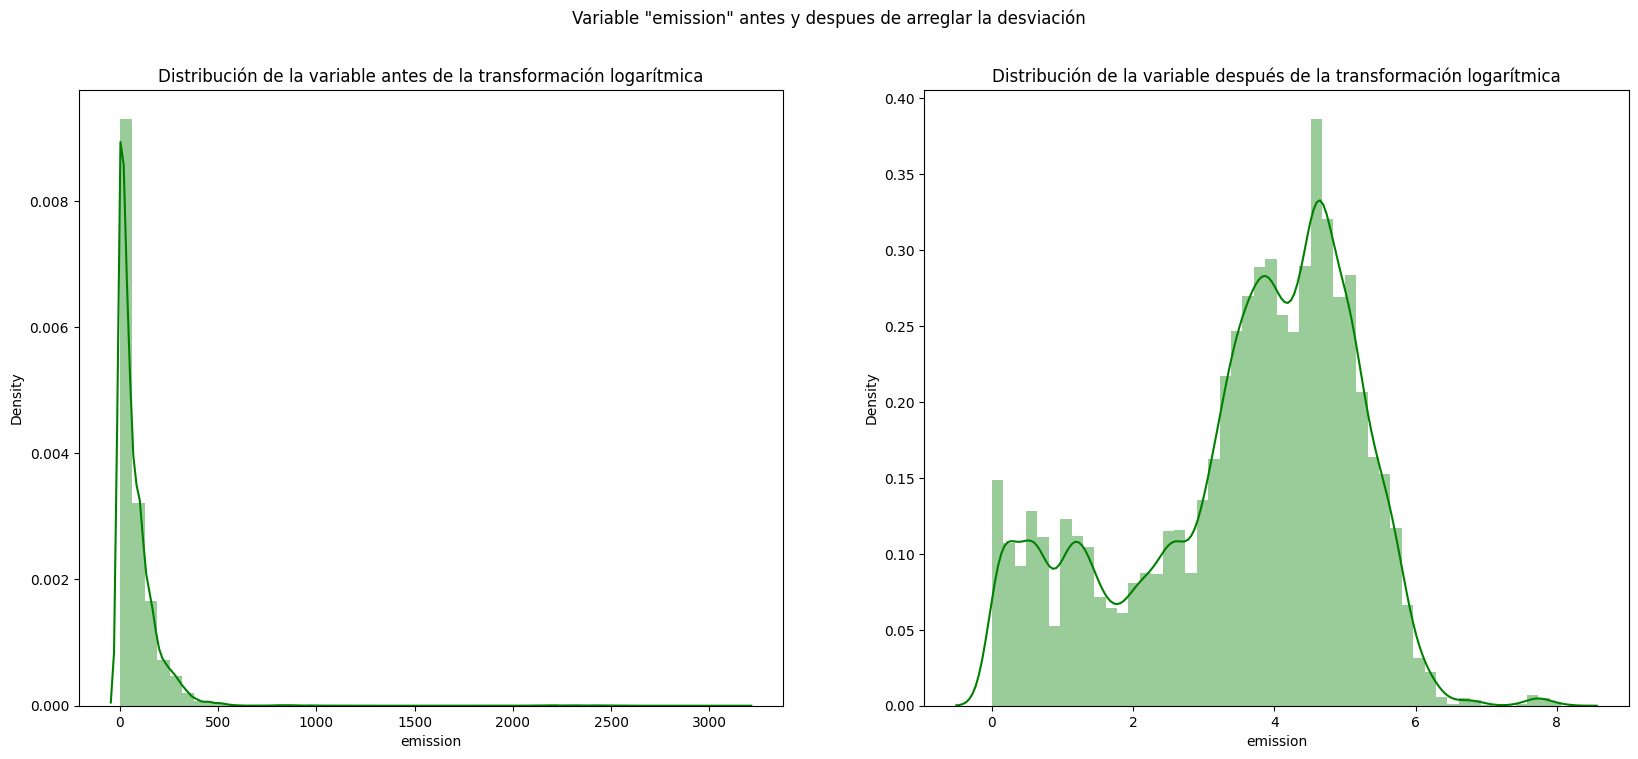

In [ ]:
# Transformación logaritmica de la variable emission
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,8))
fig.suptitle('Variable "emission" antes y despues de arreglar la desviación')

sns.distplot(train_df['emission'], color='g', ax = ax1)
ax1.set_title('Distribución de la variable antes de la transformación logarítmica')

sns.distplot(train_ndf['emission'], color='g', ax = ax2)
ax2.set_title('Distribución de la variable después de la transformación logarítmica')

plt.show()

Se buscan los valores de las emisiones iguales a cero ya que son inaportantes debido a que no tiene sentido que en un día no se produzcan emisiones de CO2

In [ ]:
# Se buscan los indices de los valores que tienen lecturas 0
cero_emisiones = list(train_ndf[train_ndf.emission == 0].index)

# Se eliminan las filas con lecturas cero en la variable objetivo
train_ndf.drop(cero_emisiones, axis = 0, inplace = True)
print('Nuevo tamaño de los datos: ',train_ndf.shape)

Nuevo tamaño de los datos:  (76638, 72)


# Generación del modelo

## Primera iteración: RandomForest

Modelo: Random Forest

Random Forest Regressor es un modelo de aprendizaje supervisado que pertenece a la familia de modelos basados en árboles y se utiliza para problemas de regresión. Es una extensión del algoritmo de Bosque Aleatorio (Random Forest), que también se utiliza en problemas de clasificación. La idea central detrás de Random Forest es construir múltiples árboles de decisión y combinar sus predicciones para obtener un modelo más robusto y generalizable.

In [ ]:
# Eliminando las variables

X = train_df.drop(['ID_LAT_LON_YEAR_WEEK', 'location', 'emission'], axis = 1).fillna(0)
y = train_df.emission

# Dividiendo los datos para entrenar y para testear
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Aplicando el modelo a los datos de entrenamiento
model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train, y_train)

# Realizando las predicciones
y_pred = model.predict(X_test)

# Aplicando la métrica del problema
print(f'RMSE: {mean_squared_error(y_test, y_pred, squared=False)}')

RMSE: 21.00099799566044


In [ ]:
# Se obtiene el error absoluto entre la emisión real y la predicción
pred_errors = X_test.copy()
pred_errors['emission'] = y_test
pred_errors['prediction'] = y_pred
pred_errors['error_absoluto'] = abs(pred_errors.prediction - pred_errors.emission)
pred_errors = pred_errors[[ 'latitude',	'longitude',	'year',	'week_no', 'emission', 'prediction', 'error_absoluto']]
pred_errors = pred_errors.sort_index()
pred_errors

latitude longitude  year week_no   emission  prediction  error_absoluto
1       -0.510    29.290  2019       1   4.025176    4.258128        0.232952
2       -0.510    29.290  2019       2   4.231381    4.104095        0.127286
14      -0.510    29.290  2019      14   4.515198    3.811539        0.703659
17      -0.510    29.290  2019      17   4.494962    4.101093        0.393868
21      -0.510    29.290  2019      21   4.286840    4.082824        0.204016
...        ...       ...   ...     ...        ...         ...             ...
79007   -3.299    30.301  2021      37  30.204075   28.397856        1.806219
79009   -3.299    30.301  2021      39  28.663029   28.378598        0.284431
79011   -3.299    30.301  2021      41  29.092640   27.882807        1.209833
79014   -3.299    30.301  2021      44  29.346270   28.285630        1.060640
79020   -3.299    30.301  2021      50  29.131205   27.928968        1.202237

[23707 rows x 7 columns]

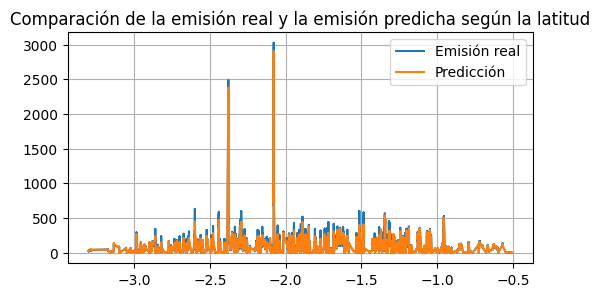

In [ ]:
# Graficando la emisión real y la predicha según la latitud

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(pred_errors["latitude"], pred_errors["emission"], label = "Emisión real")
ax.plot(pred_errors["latitude"], pred_errors["prediction"], label = "Predicción")
plt.title('Comparación de la emisión real y la emisión predicha según la latitud')
plt.legend()
plt.grid()
plt.show()

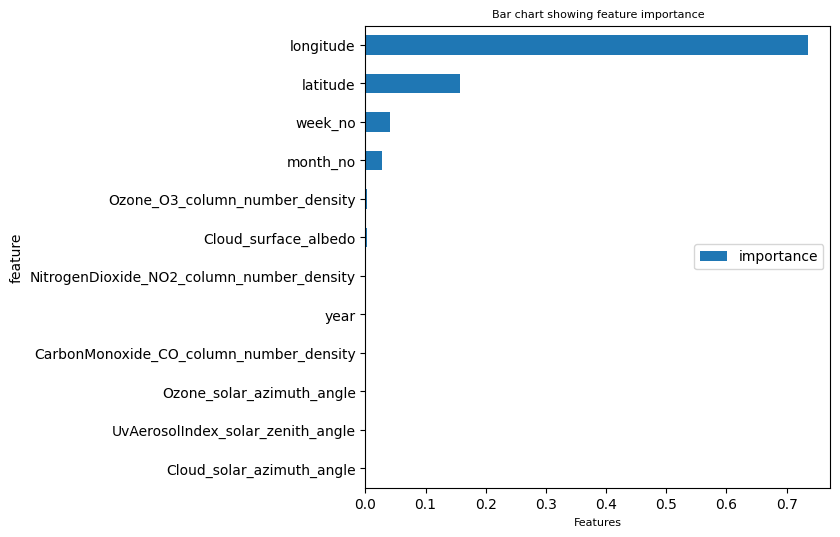

In [ ]:
impo_df = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (6, 6))
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', fontsize = 8)
plt.xlabel('Features', fontsize = 8)
plt.show()

## Segunda iteración: Efectividad de métodos supervisados

In [ ]:
# Función para el formato del error del modelo

def Formato_puntaje(z):

    #RMSE en prueba y entrenamiento
    lr_ts_score = z['test_score']*(-1)
    lr_tr_score = z['train_score']*(-1)
    lin_rmse_ts = np.sqrt(lr_ts_score)
    lin_rmse_tr = np.sqrt(lr_tr_score)
    print("RMSLE prueba: ", "{:.5f}".format(np.mean(lin_rmse_ts)), "(±", "{:.8f}".format(np.std(lin_rmse_ts)),")")
    print("RMSLE entrenamiento: ", "{:.5f}".format(np.mean(lin_rmse_tr)), "(±", "{:.8f}".format(np.std(lin_rmse_tr)),")")

In [ ]:
# Métrica para la variable 'emission' con transformación logarítmica

def RMSLE(y_real, y_pred):

    return np.sqrt(mean_squared_error(y_real, y_pred))

Se hace necesario eliminar las variables con menos correlación en relación a la variable objetivo, por lo tanto, se eliminan las variables con correlación menor a 0,01 debido a que las multiples variables presentan una correlación baja pero a la vez pueden ser determinantes en la predicción

In [ ]:
Xn = train_ndf.drop(['emission'],axis = 1).fillna(0)
yn = train_ndf['emission'].values
# Se eliminan las variables con menos correlación según los resultados del análisis
Xn = Xn.drop(['SulphurDioxide_cloud_fraction','SulphurDioxide_solar_zenith_angle','Ozone_sensor_azimuth_angle','NitrogenDioxide_solar_zenith_angle','Ozone_O3_column_number_density','CarbonMonoxide_sensor_zenith_angle','Cloud_sensor_azimuth_angle',
                           'CarbonMonoxide_sensor_altitude','NitrogenDioxide_NO2_column_number_density','Formaldehyde_solar_zenith_angle','UvAerosolIndex_sensor_altitude','NitrogenDioxide_tropopause_pressure','SulphurDioxide_sensor_zenith_angle',
                           'Ozone_O3_effective_temperature', 'Formaldehyde_cloud_fraction'],axis = 1)

Una vez eliminadas las variables con la correlación más baja, se usa el nuevo dataset para realizar la partición de los datos para entrenamiento y prueba

In [ ]:
# Partición de los datos para entrenamiento y testeo

tam_prueba = 0.1
tam_val = tam_prueba/(1-tam_prueba) # Elementos para la validación


print (Xn.shape, yn.shape)
print ("test size %.2f"%tam_prueba)
print ("val size is %.2f (relative to %.2f) "%(tam_val, 1-tam_prueba))

#Xtv, ytv son los datos que se usan para entrenar el modelo
#Xts, yts son los datos que se usan para probar el modelo (solo se usan para el testeo final de los modelos que se seleccionen)
Xtv, Xts, ytv, yts = train_test_split(Xn, yn, test_size=tam_prueba)
print (Xtv.shape, Xts.shape)

(76638, 56) (76638,)
test size 0.10
val size is 0.11 (relative to 0.90) 
(68974, 56) (7664, 56)


In [ ]:
# Variables para los modelos predictivos

estimador1 = LinearRegression()
estimador2 = DecisionTreeRegressor(max_depth=5)
estimador3 = RandomForestRegressor(n_estimators = 2,max_depth = 5)

In [ ]:
# Selección de modelos basados en su métrica

zscores = []
estimadores = [estimador1, estimador2, estimador3]
for estimator in estimadores:
    print("---------")
    z = cross_validate(estimator, Xtv, ytv, return_train_score=True,
                       return_estimator=False,
                       scoring="neg_mean_squared_error",
                       cv=ShuffleSplit(n_splits=10, test_size=tam_val))
    Formato_puntaje(z)
    zscores.append(np.mean(np.sqrt(z['test_score']*(-1))))

best = np.argmin(zscores)
print ("Seleccionado: ", best+1)
best_estimator = estimadores[best]
print ("\n Mejor modelo: ")
print (best_estimator)

---------
RMSLE prueba:  1.49334 (± 0.08635707 )
RMSLE entrenamiento:  1.45229 (± 0.00110447 )
---------
RMSLE prueba:  1.14304 (± 0.03310625 )
RMSLE entrenamiento:  1.14221 (± 0.02588166 )
---------
RMSLE prueba:  1.12348 (± 0.03285831 )
RMSLE entrenamiento:  1.12479 (± 0.03076983 )
Seleccionado:  3

 Mejor modelo: 
RandomForestRegressor(max_depth=5, n_estimators=2)


Luego de realizar los tres modelos, se observa que el mejor es el RandomForestRegressor, por lo que se va a trabajar con este modelo

### Mejora de hiperparámetros del mejor modelo

Con el fin de obtener el mejor rendimiento posible para el modelo seleccionado, el cual será el RandomForestRegressor, se realiza una iteración entre ciertos valores para encontrar el mejor para el modelo

In [ ]:
# Se busca obtener los mejores parámetros para el modelo elejido

parametros = { 'n_estimators': [5,10,15],
              'max_depth':[5,7,9]}

forest_reg = GridSearchCV(estimator = estimador3,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=tam_val),
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)
forest_reg.fit(Xtv, ytv)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.11111111111111112,
       train_size=None),
             estimator=RandomForestRegressor(max_depth=5, n_estimators=2),
             n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9], 'n_estimators': [5, 10, 15]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [ ]:
print("Mejor modelo Random Forest: ",forest_reg.best_estimator_)
print("Mejores parámetros para el modelo Random Forest: ", forest_reg.best_params_)

Mejor modelo Random Forest:  RandomForestRegressor(max_depth=9, n_estimators=15)
Mejores parámetros para el modelo Random Forest:  {'max_depth': 9, 'n_estimators': 15}


In [ ]:
Rfr = RandomForestRegressor(n_estimators = 15,max_depth = 9)
Rfr.fit(Xtv, ytv)

RandomForestRegressor(max_depth=9, n_estimators=15)

In [ ]:
# Puntaje del modelo Random Forest seleccionado

print('RMSLE del Random Forest en entrenamiento: ',"{:.5f}".format(RMSLE((ytv) , (Rfr.predict(Xtv)))))
print('RMSLE del Random Forest seleccionado: ',"{:.5f}".format(RMSLE(yts , Rfr.predict(Xts))))

RMSLE del Random Forest en entrenamiento:  0.60484
RMSLE del Random Forest seleccionado:  0.62121


#Curvas de aprendizaje

In [ ]:
def lc_plot(estimator,X,y):
    train_sizes, train_scores, valid_scores = learning_curve(estimator, X, y, train_sizes= [0.3, 0.5,0.7,0.9],
                 scoring ='neg_root_mean_squared_error', cv = ShuffleSplit(n_splits=10, test_size=tam_val))

    train_scores = np.abs(train_scores)
    valid_scores = np.abs(valid_scores)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    plt.subplots(1, figsize=(5,5))
    plt.plot(train_sizes, train_mean, '--', color="r",  label="Puntaje de entrenamiento")
    plt.plot(train_sizes, valid_mean, color="g", label="Puntaje de validación cruzada")



    plt.grid()
    plt.title("Curva de aprendizaje")
    plt.xlabel("Tamaño del conjunto de entrenamiento"), plt.ylabel("RMSLE"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    return plt

In [ ]:
Rdm_forest = RandomForestRegressor(n_estimators = 15,max_depth = 9)

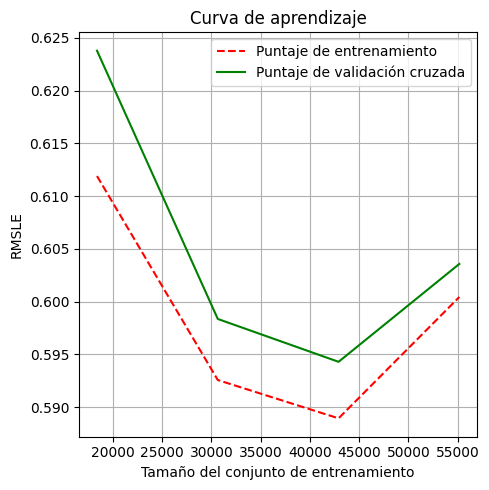

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [ ]:
lc_plot(Rdm_forest,Xtv,ytv)

# Conclusiones

* El primer modelo realizado tenía un procesamiento de datos escencial que no tomaba mucho detalle en las distribuciones de las variables ni su relación con la variable objetivo, por lo tanto, era un modelo muy sencillo que no tenía una gran precisión a la hora de realizar las predicciones.

* De los métodos utilizados, se eligio el RFR. Sin embargo, al obtener la curva de aprendizaje de este, se observó que el modelo presenta varios problemas con este caso específico, esto debido a que en la curva de aprendizaje se puede observar que el modelo no está aprendiendo lo suficiente con los datos de entrenmiento, debido a que ni los datos entrenamiento ni los datos de validación presentan un rendimiento aceptable, esto puede deberse a que el modelo es demasiado simple, los datos tomados no son representativos en tamaño o están muy mezclados

* Para solucionar los problemas presentados por este modelo, se podrían utilizar modelos más complejos, como árboles de decisión o redes neuronales. Además, se puede ver que el modelo se comporta de mejor manera aumentando los datos hasta más o menos 42 mil datos, pero de ahí en adelante, el modelo no se comporta correctamente.

